In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
# from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.patches as mpatches
import datetime
%load_ext tensorboard
numpy.random.seed(7)

In [ ]:
import scipy.io

# LOAD THE DATASET
mat = scipy.io.loadmat('/content/drive/MyDrive/m_pox/time_Series_dataset_31_7_22.mat')

In [ ]:
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten


In [ ]:
dataset = mat['mutation_timeseries']
dataset = dataset.astype('float32')

print('Dataset Shape: ', numpy.shape(dataset))

#dt=numpy.reshape(dataset,(1,9552))   # 330 x 12
#numpy.shape(dt)
#dataset=numpy.transpose(dt,axes=None);
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * .90)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

Dataset Shape:  (519, 12)
467 52


In [ ]:
def create_dataset(dataset, look_back, btch):  #This function takes 12 patients and labels 12+ith patient - (12x12)
    dataX, dataY = [], []
    z=0
    inc=1
    for i in range(0,len(dataset)-look_back,inc):
        a = dataset[i:(i+look_back)]

        dataX.append(numpy.reshape(a,(btch,12)))
        dataY.append(dataset[i+look_back])
        z+=1
    return numpy.array(dataX), numpy.array(dataY)

btch=12
look_back = 12
trainX, trainY = create_dataset(train, look_back, btch)
testX, testY = create_dataset(test, look_back, btch)

trainX = numpy.reshape(trainX, (trainX.shape[0], btch,12))
testX = numpy.reshape(testX, (testX.shape[0], btch, 12))
print(len(trainX), len(testX))

455 40


In [ ]:
model = None
def get_model(params, input_shape):
  model = Sequential()

  model.add((LSTM(units=64, return_sequences=True, input_shape=input_shape)))
  model.add(layers.Activation('linear'))
  model.add(Dropout(rate=params["dropout"]))

  model.add((LSTM(units=128, return_sequences=True)))
  model.add(layers.Activation('linear'))
  model.add(Dropout(rate=params["dropout"]))

  model.add((LSTM(units=256, return_sequences=True)))
  model.add(layers.Activation('linear'))
  model.add(Dropout(rate=params["dropout"]))

  model.add((LSTM(units=512, return_sequences=True)))
  model.add(layers.Activation('linear'))
  model.add(Dropout(rate=params["dropout"]))

  model.add(LSTM(units=512, return_sequences=False))
  model.add(layers.Activation('linear'))
  model.add(Dropout(rate=params["dropout"]))

  model.add(layers.Dropout(0.10))
  model.add(layers.Dense(256))
  model.add(layers.Activation('linear'))
  model.add(layers.Dropout(0.10))
  model.add(layers.Dense(128))
  model.add(layers.Activation('linear'))
  model.add(layers.Dropout(0.10))
  model.add(Dense(12))

  model.compile(loss=params["loss"],
                optimizer=params["optimizer"],
                metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

  return model

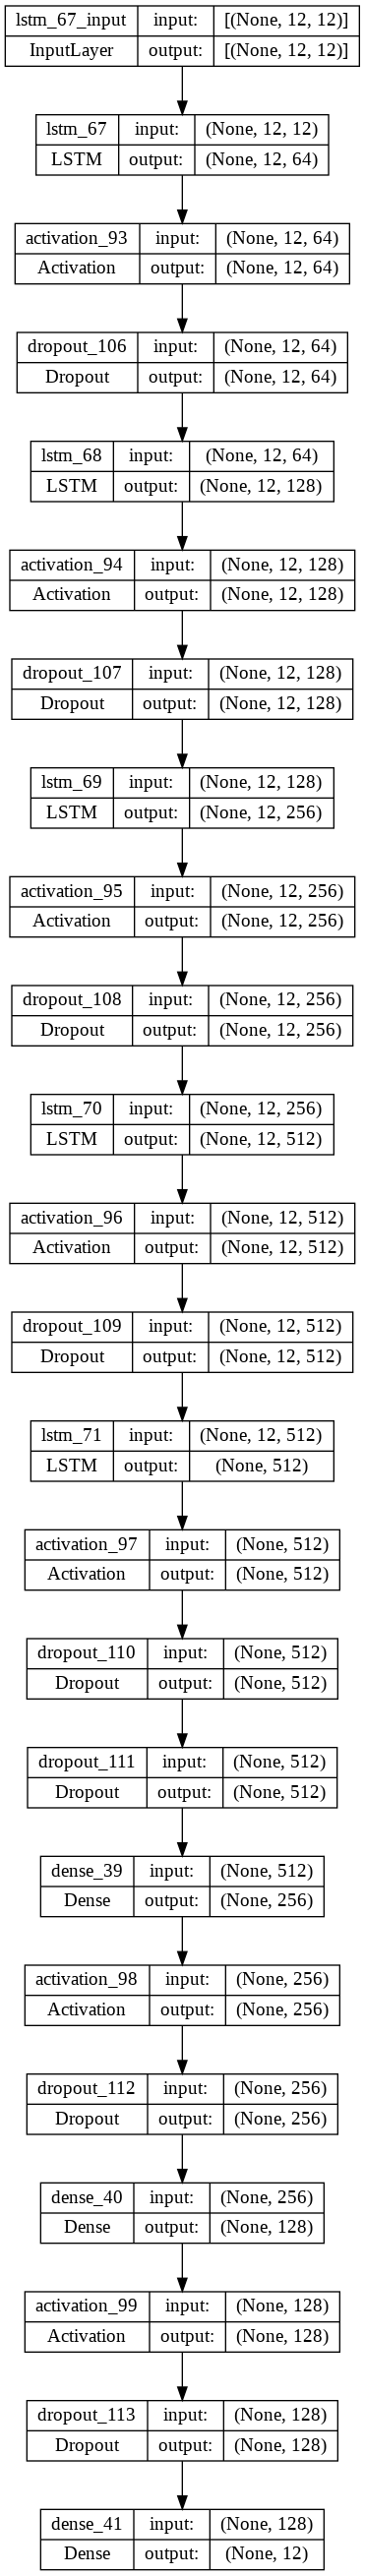

In [ ]:
from keras.utils.vis_utils import plot_model
model2 = get_model(params=params, input_shape=(btch, 12))
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!rm -r logs

In [ ]:
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min',
# patience=params["es_patience"])
# history=model.fit(trainX, trainY, validation_split=0.30,epochs=300, batch_size=12, verbose=2)
params = {
	"loss": "mse",
	"optimizer": "adam",
	"dropout": 0.1,
	"lstm_units": 300,
	"epochs": 100,
	"batch_size": 6,
	"es_patience" : 10
}

model = get_model(params=params, input_shape=(btch, 12))


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
	trainX,
	trainY,
	validation_split=0.05,
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=1,
	callbacks=[tensorboard_callback]
)



Epoch 1/100
72/72 [==============================] - 9s 45ms/step - loss: 0.1069 - root_mean_squared_error: 0.3270 - mean_absolute_error: 0.2126 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.0614
Epoch 2/100
72/72 [==============================] - 2s 22ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - mean_absolute_error: 0.0763 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.0523
Epoch 3/100
72/72 [==============================] - 2s 21ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - mean_absolute_error: 0.0749 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0667 - val_mean_absolute_error: 0.0651
Epoch 4/100
72/72 [==============================] - 2s 22ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - mean_absolute_error: 0.0628 - val_loss: 4.1787e-04 - val_root_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.0189
Epoch 5/100
72/72 [==============================] -

In [ ]:

%tensorboard --logdir logs/fit

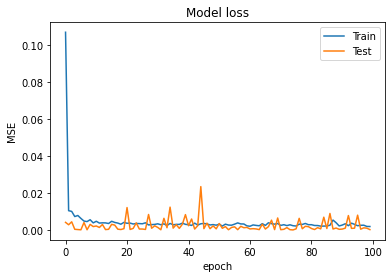

In [ ]:
# model.compile(loss='mean_squared_error', optimizer='adam')
# history=model.fit(trainX, trainY, validation_split=0.30,epochs=300, batch_size=12, verbose=2)

plt.plot(history.history['loss'])
plt.plot(numpy.array(history.history['val_loss']))
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

2/2 [==============================] - 0s 9ms/step
Train Score: 0.08 RMSE
Test Score: 0.09 RMSE


Text(30.25, 0.5, 'Mutation Rate in %')

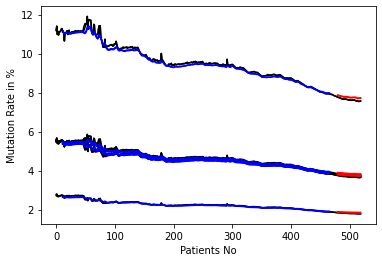

In [ ]:
trainPredict = model.predict(trainX, verbose=1)
testPredict = model.predict(testX, verbose=1)


# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

#calculating error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

dset=scaler.inverse_transform(dataset)
# 624+148=772
# shift train predictions for plotting
trainPredictPlot = numpy.empty([len(trainX)+12,12])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[btch-1:len(trainX)+btch-1] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty([len(dataset),12])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainX)+btch*2:len(trainX)+len(testY)+btch*2] =  testPredict
# plot baseline and predictions
plt.plot(dset,color="black")
plt.plot(trainPredictPlot,color="blue")
plt.plot(testPredictPlot,color="red")
plt.savefig('Raw_data_test.png',dpi=300)
plt.xlabel('Patients No')
plt.ylabel('Mutation Rate in %')
# plt.show()

1/1 [==============================] - 0s 23ms/step


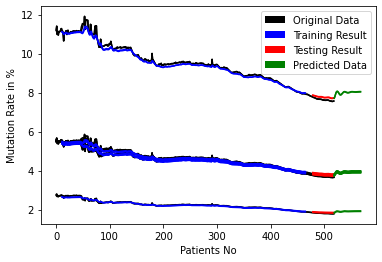

In [ ]:
PD=[]
Dt=testX[39]
# Dt=dataset[3066]
# Dt=scaler.fit_transform(ttf)
# PD.append(Dt[len(testY)-btch:len(testY)])                   #taking last element from test prediction
postData=numpy.array(Dt)
postData=numpy.reshape(postData, (1,btch,12))
#print(postData)
futureData=[]
futureData.append(postData)
temp=[]
result=[]
fuData=[]
futNo=50
for i in range(futNo):

    future = model.predict(futureData[i])
    postData=numpy.array(future)
    ftd=numpy.empty([btch,12])
    nk=numpy.array(futureData[i])
    ftd[0:btch-1,0:12]=nk[0,1:btch]
#     print(numpy.shape(postData))
    ftd[btch-1,:]=postData[:]

    temp=numpy.reshape(ftd,(1,btch,12))
#     print(numpy.shape(temp))
    futureData.append(temp)


    postData=numpy.reshape(postData, (1,1,12))
    result.append(postData)

fuData=numpy.reshape(result,(futNo,12))


trainPredictPlot = numpy.empty([len(trainX)+12,12])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[btch-1:len(trainX)+btch-1] = trainPredict #+.03
# shift test predictions for plotting
testPredictPlot = numpy.empty([len(dataset),12])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainX)+btch*2:len(trainX)+len(testY)+btch*2] =  testPredict #+.02


bk=len(dataset); # total data
now=futNo; # total predicted data

futurePredictPlot=numpy.empty([bk+now,12])
futurePredictPlot[:, :] = numpy.nan
futurePredictPlot[bk:(bk+now), 0:12] = scaler.inverse_transform(fuData)

# plot baseline and predictions

plt.plot(dset,color="black",label='Original Data')
plt.plot(trainPredictPlot,color="blue",label='Training Result')
plt.plot(testPredictPlot,color="red",label='Testing Result')
plt.plot(futurePredictPlot,color="green",label='Predicted Data')



red_patch = mpatches.Patch(color='black', label='Original Data',linewidth=0)
red_patch1 = mpatches.Patch(color='blue', label='Training Result',linewidth=0)
red_patch2= mpatches.Patch(color='red', label='Testing Result',linewidth=0)
red_patch3 = mpatches.Patch(color='green', label='Predicted Data',linewidth=0)
plt.legend(handles=[red_patch,red_patch1,red_patch2,red_patch3])
plt.xlabel('Patients No')
plt.ylabel('Mutation Rate in %')
plt.savefig('predictioin_pox.png',dpi=300)
plt.show()

In [ ]:

futurePredictPlot[568]


array([3.93558359, 8.03419113, 3.90576124, 3.88959026, 1.90581965,
       3.98026228, 3.94828558, 8.05398655, 3.89410043, 3.94476604,
       1.93719852, 3.9899199 ])